In [1]:
# import the dependencies
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, CategoricalEncoder
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

# Read in the Data and Prepare for Fitting Models

In [2]:
df = pd.read_csv("reduced-data3.csv")

In [3]:
df.shape

(5872, 71)

In [4]:
df.head()

,CASEID,V6309,V5114,V5118,V5113,V5115,V5112,V4428,V4433,V6305,...,PDREC,AGREC,SIMREC,SOCREC,ALCDREC,ALCAREC,DRGDREC,DRGAREC,PTSDREC,NAPREC
0,20001,NO,VERY,A LITTLE,SOMEWHAT,SOMEWHAT,SOMEWHAT,A LITTLE TRUE,VERY TRUE,YES,...,> 1 Year,> 1 Year,>6 Months & <= 1 Year,NaN,>1 Month & <=6 Months,>1 Month & <=6 Months,> 1 Year,> 1 Year,> 1 Year,NaN
1,20002,NO,A LITTLE,A LITTLE,SOMEWHAT,A LITTLE,SOMEWHAT,A LITTLE TRUE,NOT TRUE AT ALL,NO,...,NaN,NaN,> 1 Year,>1 Month & <=6 Months,NaN,NaN,NaN,NaN,NaN,NaN
2,20003,NO,NOT AT ALL,NOT AT ALL,NOT AT ALL,NOT AT ALL,NOT AT ALL,NOT TRUE AT ALL,NOT TRUE AT ALL,NO,...,NaN,NaN,NaN,NaN,NaN,NaN,> 1 Year,> 1 Year,NaN,NaN
3,20004,NO,SOMEWHAT,SOMEWHAT,A LITTLE,A LITTLE,A LITTLE,A LITTLE TRUE,NOT TRUE AT ALL,NO,...,NaN,NaN,NaN,NaN,> 1 Year,> 1 Year,> 1 Year,> 1 Year,NaN,NaN
4,20005,NO,A LITTLE,A LITTLE,A LITTLE,A LITTLE,SOMEWHAT,SOMEWHAT TRUE,A LITTLE TRUE,NO,...,NaN,NaN,>6 Months & <= 1 Year,NaN,> 1 Year,> 1 Year,NaN,NaN,NaN,NaN


# Convert Categorical Variables to 0-1 Coded Variables
We use Pandas `get_dummies` to convert the categorical variables to one-hot encoded variables for fitting

In [5]:
num_attribs = ['AGE']
response = ['V6309']
cat_attribs = df.columns.tolist()
cat_attribs.remove('V6309')
cat_attribs.remove('AGE')
cat_attribs.remove('CASEID')

In [6]:
df_with_dummies = pd.get_dummies(df[cat_attribs], dummy_na=True, drop_first=True)
df_with_dummies['AGE'] = df['AGE']
df_with_dummies['response'] = df['V6309']
df_with_dummies.head()

,V5114_DK,V5114_INAP,V5114_NOT AT ALL,V5114_SOMEWHAT,V5114_VERY,V5114_nan,V5118_DK,V5118_INAP,V5118_NOT AT ALL,V5118_SOMEWHAT,...,DRGAREC_nan,PTSDREC_> 1 Year,PTSDREC_>1 Month & <=6 Month,PTSDREC_>6 Months & <= 1 Year,PTSDREC_nan,NAPREC_> 1 Year,NAPREC_>1 Month & <=6 Month,NAPREC_nan,AGE,response
0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,54,NO
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,36,NO
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,34,NO
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,36,NO
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,31,NO


# Set Aside Testing Data

In [7]:
# Make a train-test split:
train_set, test_set = train_test_split(df_with_dummies, random_state=1, stratify=df_with_dummies['response'])

In [8]:
print(train_set.shape, test_set.shape)

(4404, 221) (1468, 221)


In [9]:
# What is the distribution of the response in the training and testing data
print("train: ")
print(train_set['response'].value_counts())
print("test: ")
print(test_set['response'].value_counts())

train: 
NO     4130
YES     274
Name: response, dtype: int64
test: 
NO     1376
YES      92
Name: response, dtype: int64


In [10]:
# We will need to identify the categorical attributes for later
cat_attribs = df_with_dummies.columns.tolist()
cat_attribs.remove('AGE')
cat_attribs.remove('response')
len(cat_attribs)

219

# Use Scikit-Learn Pipeline
The pipeline can be used to automate selection from a dataframe and transformation

In [11]:
# Define a method to select attributes from a DataFrame
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# We will need this later
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('std_scaler', StandardScaler())
    #('encoder', LabelBinarizer(sparse=False, handle_unknown='ignore'))
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])


In [12]:
y_train = pd.get_dummies(train_set['response'], drop_first=True).values

# Prepare the training data with the pipeline above
X_train_prepared = full_pipeline.fit_transform(train_set)
X_train_prepared

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.47333761, -0.01507043, -0.02131523, ..., -0.05227084,
        -0.02131523,  0.08555293],
       [-0.83996019, -0.01507043, -0.02131523, ..., -0.05227084,
        -0.02131523,  0.08555293],
       [ 0.47333761, -0.01507043, -0.02131523, ..., -0.05227084,
        -0.02131523,  0.08555293],
       ...,
       [ 0.09810967, -0.01507043, -0.02131523, ..., -0.05227084,
        -0.02131523,  0.08555293],
       [ 1.69282842, -0.01507043, -0.02131523, ..., -0.05227084,
        -0.02131523,  0.08555293],
       [-0.7461532 , -0.01507043, -0.02131523, ..., -0.05227084,
        -0.02131523,  0.08555293]])

In [13]:
X_train_prepared.shape

(4404, 220)

In [14]:
y_test = pd.get_dummies(test_set.response, drop_first=True).values

X_test_prepared = full_pipeline.transform(test_set)
X_test_prepared.shape

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(1468, 220)

# Consider a Decision Tree Classifier

In [15]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_prepared, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
y_test_pred = tree_clf.predict(X_test_prepared)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1376
           1       0.52      0.52      0.52        92

   micro avg       0.94      0.94      0.94      1468
   macro avg       0.74      0.74      0.74      1468
weighted avg       0.94      0.94      0.94      1468



# Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_jobs=-1)
forest_clf.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
y_test_pred_rf = forest_clf.predict(X_test_prepared)

In [20]:
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1376
           1       0.72      0.23      0.35        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.84      0.61      0.66      1468
weighted avg       0.94      0.95      0.93      1468



# Use GridSearchCV to Find Good Parameter Values

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100, 200, 300, 500, 1000]}
grid_rf = GridSearchCV(forest_clf, param_grid, verbose=3, n_jobs=-1)
grid_rf.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   2 out of  18 | elapsed:    2.7s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  16 out of  18 | elapsed:    6.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    6.8s finished
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200, 300, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [22]:
print(grid_rf.best_score_)

0.9418710263396912


In [23]:
print(grid_rf.best_params_)

{'n_estimators': 500}


In [24]:
param_grid = {'n_estimators': [400, 500, 600, 700, 800]}
grid_rf = GridSearchCV(forest_clf, param_grid, verbose=3, n_jobs=-1)
grid_rf.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    2.7s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    4.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.8s finished
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [400, 500, 600, 700, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [25]:
print(grid_rf.best_params_)

{'n_estimators': 600}


In [26]:
attributes = num_attribs + cat_attribs
feature_importances = grid_rf.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.0995963162198873, 'V6301_YES'),
 (0.0747045584424761, 'V6305_YES'),
 (0.03622885397843664, 'AGE'),
 (0.013212274349244909, 'V6114_YES'),
 (0.011889521790023687, 'V6143_YES'),
 (0.011442613731487129, 'PTSDLT_Present'),
 (0.011078848236470807, 'V6114_NO'),
 (0.010571964459720456, 'DEPREC_nan'),
 (0.01031153525848248, 'DEPLT1_Present'),
 (0.01028224615507755, 'V4433_VERY TRUE'),
 (0.009962852141359226, 'EDCAT_12 Years'),
 (0.009573152502083404, 'V5225_INAP'),
 (0.009360429123720043, 'V5918_OFTEN'),
 (0.00926156095327707, 'PTSDREC_nan'),
 (0.0091666367428997, 'REL_Protestant'),
 (0.00905370255612979, 'CDLT_Present'),
 (0.008955894934562201, 'V5112_VERY'),
 (0.008826677829080865, 'V5118_SOMEWHAT'),
 (0.008777922642079227, 'V6649_NO'),
 (0.008692848320003782, 'SEX_Male'),
 (0.008397261100760268, 'V4428_VERY TRUE'),
 (0.00832416600871236, 'V6215_TWO OR MORE YES RESPONSES IN U1-U12'),
 (0.008301752630639134, 'EMP_Working, incl. temp. laid off, matern./s'),
 (0.008200672953885529, 'V102_VER

In [27]:
y_test_pred_rf = grid_rf.best_estimator_.predict(X_test_prepared)

In [28]:
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1376
           1       0.92      0.13      0.23        92

   micro avg       0.94      0.94      0.94      1468
   macro avg       0.93      0.56      0.60      1468
weighted avg       0.94      0.94      0.92      1468



# Logistic Regression with L1 Regularization

In [29]:
### from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, multi_class='auto', n_jobs=-1,verbose=3)

In [30]:
classifier.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 870 epochs took 477 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.9min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='auto',
          n_jobs=-1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=3, warm_start=False)

In [31]:
print(f"Training Data Score: {classifier.score(X_train_prepared, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_prepared, y_test)}")

Training Data Score: 0.9620799273387829
Testing Data Score: 0.9475476839237057


In [32]:
y_test_pred = classifier.predict(X_test_prepared)

In [33]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1376
           1       0.62      0.42      0.50        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.79      0.70      0.74      1468
weighted avg       0.94      0.95      0.94      1468



In [34]:
# We can visualize where the classifier is making errors using a confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mx = confusion_matrix(y_test, y_test_pred)
conf_df= pd.DataFrame(conf_mx, index=classifier.classes_, columns=classifier.classes_)
sns.heatmap(conf_df, annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

<Figure size 640x480 with 2 Axes>

# Search for a Model that Fits Better

In [35]:
param_grid = {'C': [0.01, 0.1, 1, 5, 10, 50]}

In [36]:
grid = GridSearchCV(classifier, param_grid, verbose=3, n_jobs=-1)

In [37]:
grid.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   2 out of  18 | elapsed:   17.1s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:   43.2s remaining:   43.2s
[Parallel(n_jobs=-1)]: Done  16 out of  18 | elapsed:  1.1min remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.2min finished
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 637 epochs took 9 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='auto',
          n_jobs=-1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=3, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [38]:
grid.best_params_

{'C': 0.1}

In [39]:
param_grid = {'C': [0.01, 0.02, 0.05, 0.1, 0.15, 0.20, 0.5]}

In [40]:
grid = GridSearchCV(classifier, param_grid, verbose=3, n_jobs=-1)
grid.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    8.9s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:   21.6s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   29.1s finished
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 638 epochs took 9 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='auto',
          n_jobs=-1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=3, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [41]:
grid.best_params_

{'C': 0.1}

In [42]:
grid.best_score_

0.9500454132606722

In [45]:
param_grid = {'C': [0.1, 0.25, 0.5]}
grid = GridSearchCV(classifier, param_grid, verbose=3, n_jobs=-1)
grid.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    9.5s remaining:   33.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   11.6s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 770 epochs took 8 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='auto',
          n_jobs=-1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=3, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.1, 0.25, 0.5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=3)

In [46]:
grid.best_params_

{'C': 0.5}

# Look at the Coefficients for the Model

In [43]:
# The estimated coefficients
final_model = grid.best_estimator_
fit_coefs = final_model.coef_

for feat_imp in sorted(zip(fit_coefs[0], attributes), reverse=True):
    print(feat_imp)

(1.3177261442024035, 'V6301_YES')
(0.31496479309564157, 'V6305_YES')
(0.16614308374566397, 'V5112_VERY')
(0.13512150936645947, 'RACE_Other')
(0.12350822513698245, 'ALCDREC_>6 Months & <= 1 Year')
(0.12244124795428828, 'GADLT2_Present')
(0.10925772039676565, 'V6143_YES')
(0.08796903930691181, 'DRGDLT_Present')
(0.08705935499462047, 'V6649_YES')
(0.08372262429724496, 'V5114_VERY')
(0.07621223371950332, 'MANREC_> 1 Year')
(0.07568347493475322, 'DEPREC_>1 Month & <=6 Months')
(0.07047599023655027, 'CDLT_Present')
(0.06986910050610946, 'AGOLT2_Present')
(0.06316123370993511, 'DEPREC_> 1 Year')
(0.04048132000073448, 'PTSDREC_>1 Month & <=6 Month')
(0.04006340247112914, 'SIMREC_>1 Month & <=6 Months')
(0.03803443903940499, 'PTSDREC_> 1 Year')
(0.03705600086858265, 'SIMREC_nan')
(0.03568339032434916, 'SOCREC_>1 Month & <=6 Months')
(0.03564872459374279, 'V102_FAIR')
(0.034247511502114386, 'MARSTAT_Marswd')
(0.034041175668555815, 'V6749_YES')
(0.03215963155361504, 'V4433_VERY TRUE')
(0.02581290

In [44]:
final_model = grid.best_estimator_

In [45]:
y_test_pred = final_model.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1376
           1       0.69      0.41      0.52        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.83      0.70      0.75      1468
weighted avg       0.94      0.95      0.95      1468



# The ROC Curve for our Classifier

In [46]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(final_model, X_train_prepared, y_train, cv=3, method="decision_function", n_jobs=-1)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
#y_train_0 = pd.get_dummies(y_train, drop_first=True).values
y_train_0 = y_train

In [51]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

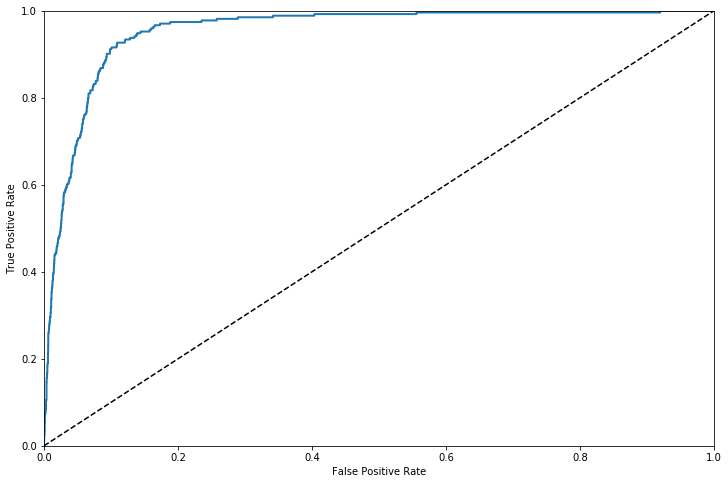

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [53]:
from sklearn.metrics import precision_recall_curve

In [54]:
y_scores = cross_val_predict(final_model, X_train_prepared, y_train_0.reshape((-1,1)), cv=3, method="decision_function", n_jobs=-1)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

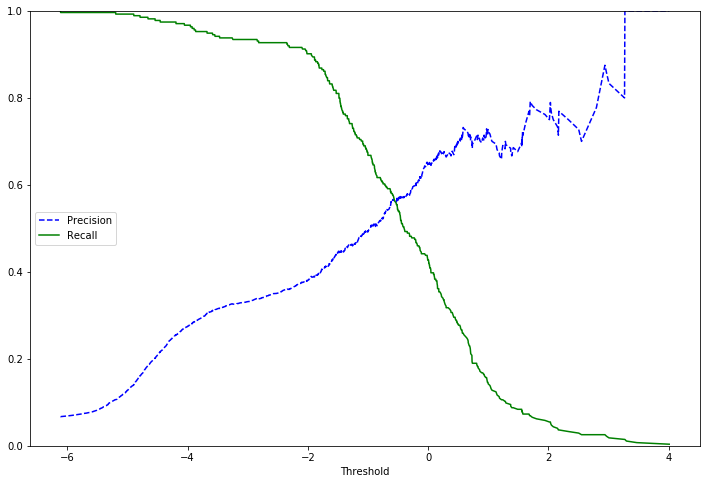

In [56]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [60]:
plt.savefig("newprecvsrecall.png")

<Figure size 432x288 with 0 Axes>

# Compare the ROC Curves - Random Forest and L1 Logistic Regression

In [61]:
y_probas_forest = cross_val_predict(grid_rf.best_estimator_, X_train_prepared, y_train_0, cv=3, method="predict_proba")

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [62]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_0, y_scores_forest)

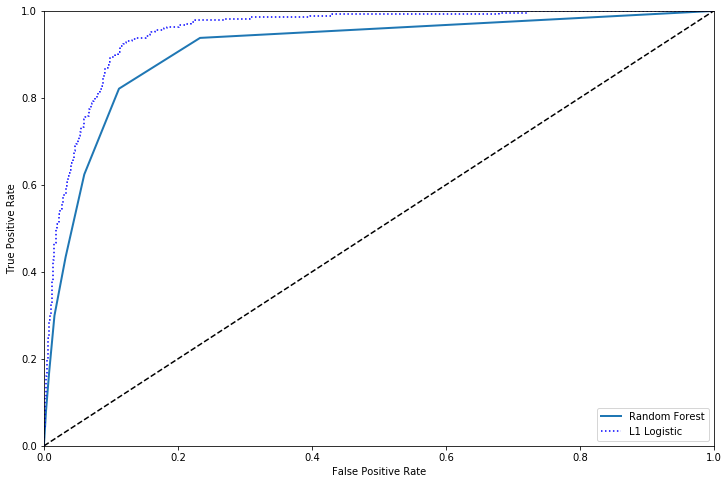

In [63]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", label="L1 Logistic")
plt.legend(loc="lower right")
plt.show()

# AdaBoost

In [64]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf =  AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
                           algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train_prepared, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=500, random_state=None)

In [65]:
print(f"Training Data Score: {ada_clf.score(X_train_prepared, y_train)}")
print(f"Testing Data Score: {ada_clf.score(X_test_prepared, y_test)}")

Training Data Score: 0.9543596730245232
Testing Data Score: 0.944141689373297


In [66]:
print(classification_report(y_test, ada_clf.predict(X_test_prepared)))

              precision    recall  f1-score   support

          NO       0.96      0.98      0.97      1376
         YES       0.57      0.43      0.49        92

   micro avg       0.94      0.94      0.94      1468
   macro avg       0.77      0.71      0.73      1468
weighted avg       0.94      0.94      0.94      1468



In [67]:
param_grid = {'n_estimators': [250, 500, 750, 1000, 1500]}
grid_ada = GridSearchCV(ada_clf, param_grid, verbose=3, n_jobs=-1)
grid_ada.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    9.7s remaining:   26.9s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   15.8s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   21.6s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=500, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [250, 500, 750, 1000, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [68]:
grid_ada.best_score_

0.9459582198001817

In [69]:
grid_ada.best_params_

{'n_estimators': 250}

In [70]:
param_grid = {'n_estimators': [100, 150, 200, 250, 300]}
grid_ada = GridSearchCV(ada_clf, param_grid, verbose=3, n_jobs=-1)
grid_ada.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    2.9s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    4.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=500, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [71]:
grid_ada.best_params_

{'n_estimators': 100}

In [72]:
param_grid = {'n_estimators': [50, 75, 100]}
grid_ada = GridSearchCV(ada_clf, param_grid, verbose=3, n_jobs=-1)
grid_ada.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.1s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=500, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 75, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=3)

In [73]:
grid_ada.best_params_

{'n_estimators': 75}

In [74]:
feature_importances = grid_ada.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.09333333333333334, 'V6301_YES'),
 (0.05333333333333334, 'EDCAT_16+ Years'),
 (0.04, 'V5225_INAP'),
 (0.04, 'V5113_VERY'),
 (0.04, 'V102_VERY GOOD'),
 (0.04, 'SEX_Male'),
 (0.04, 'GADLT2_Present'),
 (0.04, 'EDCAT_13-15 Years'),
 (0.04, 'AGE'),
 (0.02666666666666667, 'V6649_YES'),
 (0.02666666666666667, 'V6305_YES'),
 (0.02666666666666667, 'V5118_VERY'),
 (0.02666666666666667, 'V5114_VERY'),
 (0.02666666666666667, 'V5112_VERY'),
 (0.02666666666666667, 'V4428_nan'),
 (0.02666666666666667, 'V4428_NOT TRUE AT ALL'),
 (0.02666666666666667, 'V101_FAIR'),
 (0.02666666666666667, 'SIMLT_Present'),
 (0.02666666666666667, 'RACE_White'),
 (0.02666666666666667, 'MARSTAT_Marnev'),
 (0.02666666666666667, 'AABLT_Present'),
 (0.013333333333333334, 'V6649_NO'),
 (0.013333333333333334, 'V6215_TWO OR MORE YES RESPONSES IN U1-U12'),
 (0.013333333333333334, 'V6143_nan'),
 (0.013333333333333334, 'V6143_YES'),
 (0.013333333333333334, 'V6114_NO'),
 (0.013333333333333334, 'V5918_SOMETIMES'),
 (0.013333333333

# Support Vector Machine

In [75]:
from sklearn.svm import SVC
svc_clf = SVC(kernel='rbf')
svc_clf.fit(X_train_prepared, np.ravel(y_train_0))

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [76]:
svc_clf.score(X_train_prepared, np.ravel(y_train_0))

0.9747956403269755

In [77]:
y_test_0 = np.ravel(pd.get_dummies(y_test, drop_first=True))
svc_clf.score(X_test_prepared, y_test_0)

0.9495912806539509

In [78]:
y_test_pred = svc_clf.predict(X_test_prepared)

In [79]:
print(classification_report(y_test_0, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1376
           1       0.91      0.22      0.35        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.93      0.61      0.66      1468
weighted avg       0.95      0.95      0.93      1468



In [80]:
param_grid = {'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_svc = GridSearchCV(svc_clf, param_grid, n_jobs=-1, verbose=3)
grid_svc.fit(X_train_prepared, y_train_0)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   2 out of  18 | elapsed:    1.6s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  16 out of  18 | elapsed:    3.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.0s finished
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [81]:
grid_svc.best_params_

{'C': 2.0}

In [82]:
y_pred = grid_svc.best_estimator_.predict(X_test_prepared)

In [83]:
print(classification_report(y_test_0, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1376
           1       0.78      0.35      0.48        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.87      0.67      0.73      1468
weighted avg       0.95      0.95      0.94      1468



Computing regularization path ...


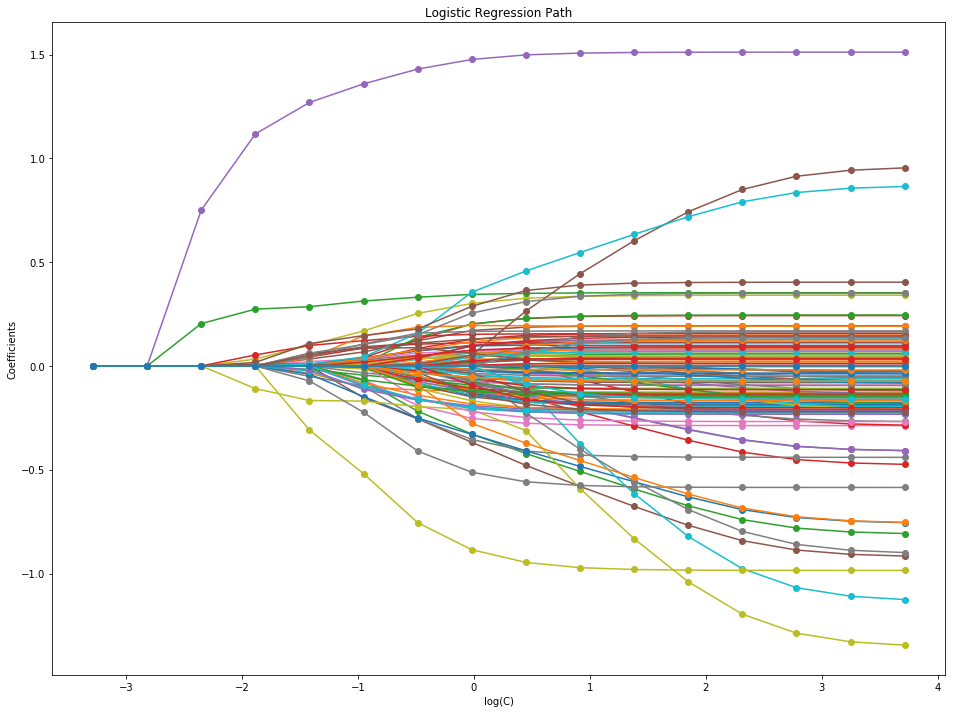

In [84]:
from sklearn import linear_model
from sklearn.svm import l1_min_c

X = X_train_prepared
y = y_train

#X /= X.max()  # Normalize X to speed-up convergence

# #############################################################################
# Demo path functions

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
#start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True, n_jobs=-1)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
#print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.figure(figsize=(16,12))
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

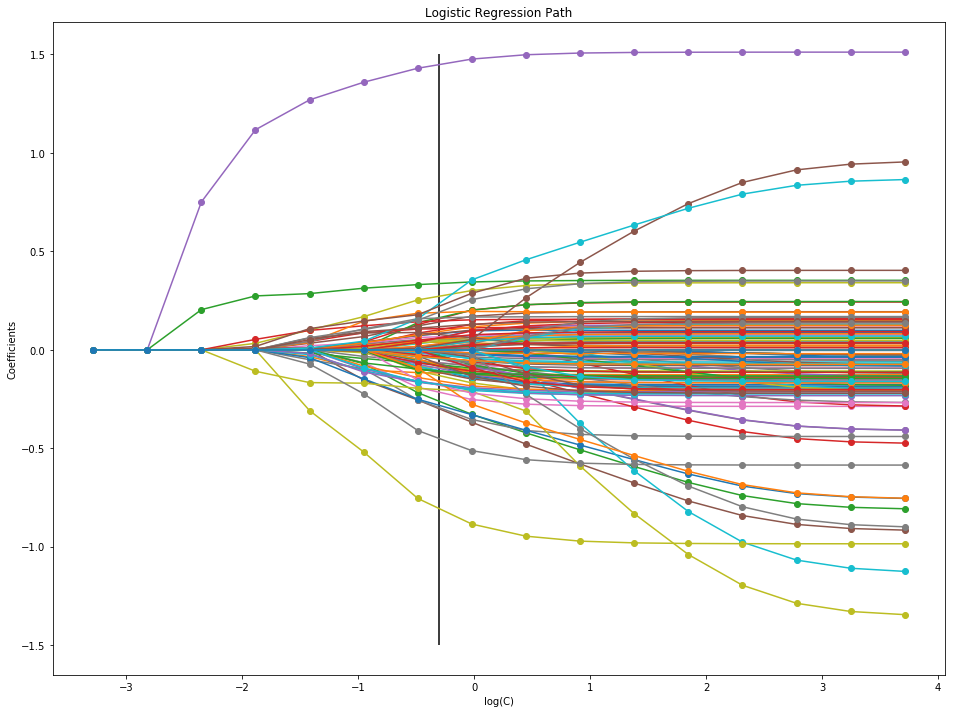

In [85]:
coefs_ = np.array(coefs_)
plt.figure(figsize=(16,12))
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.vlines(np.log10(0.5), ymin=-1.5, ymax=1.5)
plt.axis('tight')
plt.show()

Text(0, 0.5, 'Precisions')

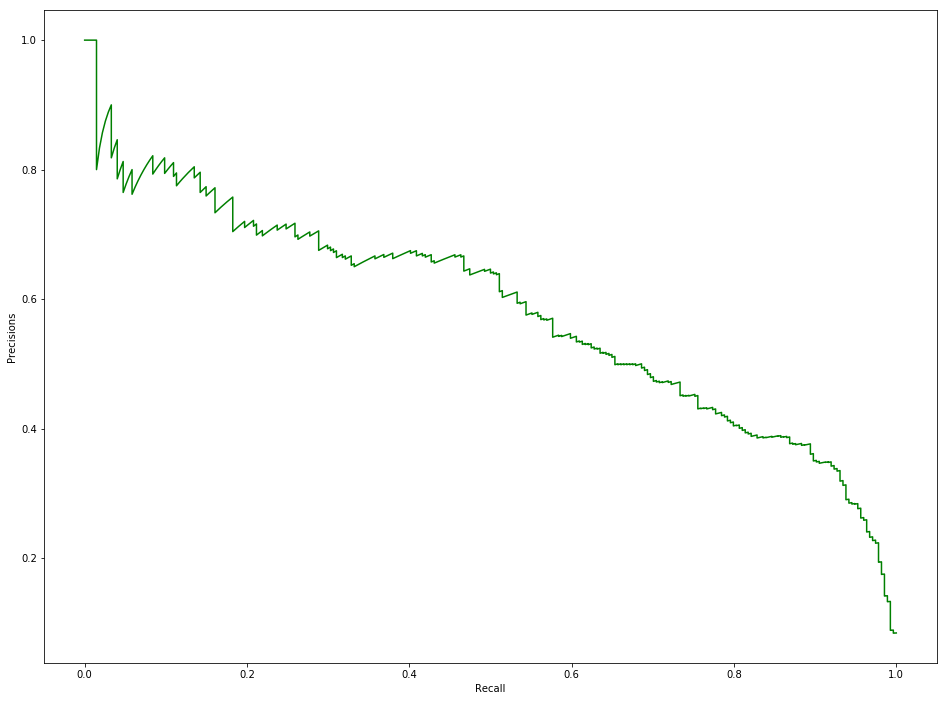

In [87]:
plt.figure(figsize=(16,12))
plt.plot(recalls, precisions, 'g-')
plt.xlabel('Recall')
plt.ylabel('Precisions')

In [88]:
y_pred_recall8 = (y_scores > -2)

In [90]:
print(classification_report(y_train_0, y_pred_recall8))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      4130
           1       0.39      0.82      0.53       274

   micro avg       0.91      0.91      0.91      4404
   macro avg       0.69      0.87      0.74      4404
weighted avg       0.95      0.91      0.92      4404



In [91]:
confusion_matrix(y_train_0, y_pred_recall8)

array([[3786,  344],
       [  50,  224]], dtype=int64)

In [92]:
confusion_matrix(y_train, final_model.predict(X_train_prepared))

array([[4072,   58],
       [ 122,  152]], dtype=int64)

In [93]:
confusion_matrix(y_test, final_model.predict(X_test_prepared))

array([[1355,   21],
       [  46,   46]], dtype=int64)